# 2D Design Template

# Overview

The purpose of this project is for you to apply what you have learnt in this course. This includes working with data and visualizing it, create model of linear regression or logistic regression, as well as using metrics to measure the accuracy of your model. 

Please find the project handout description in the following link:
- [DDW-MU-Humanities Handout](https://sutdapac-my.sharepoint.com/:b:/g/personal/franklin_anariba_sutd_edu_sg/EaonbI8dXvFHr5I75zUAhGEBXflfC4aZEqtcxPYHS5Jciw?e=s6UTbq)
- [DDW-MU-SocialStudies Handout](https://sutdapac-my.sharepoint.com/:b:/g/personal/franklin_anariba_sutd_edu_sg/ETaVN6doTnJElS0Egw34XYQB_VYCwijjNk_05Ft4RctYjg?e=X8iVbw)

There are two parts.
- Part 1 is related to predicting COVID-19 deaths
- Part 2 is open ended and you can find the problem of your interest as long as it is related to COVID-19. The only requirements are the following:
    - The problem can be modelled either using Linear Regression (or Multiple Linear Regression) or Logistic Regression. This means either you are working with continous numerical data or classification. You are not allowed to use Neural Networks or other Machine Learning models.
    - You must use Python and Jupyter Notebook

The following tasks are a general guide to help you do your project for Part 2:
1. Find an interesting problem which you can solve either using Linear Regression or Classification
1. Find a dataset to build your model. You can use [Kaggle](https://www.kaggle.com/datasets) to find your datasets.
1. Use plots to visualize and understand your data.
1. Create training and test data set.
1. Build your model
1. Use metrics to evaluate your model.
1. Improve your model

## Deliverables

You need to submit this Jupyter notebook together with the dataset into Vocareum. Use the template in this notebook to work on this project.

## Rubrics

The rubrics for the scoring can be found in [this link](https://sutdapac-my.sharepoint.com/:b:/g/personal/franklin_anariba_sutd_edu_sg/EdLkuzyCrrJBp5QfVGtdHn8Bj3_epWiQMqv2mwyEei_3JQ?e=fLB0QN).

## Students Submission

Student's Name:
- Ng Jie Lin 1005476
- Umang Gupta 1005393
- Lee Cheng Xin 1005056
- Yeo Ke Wei 1005165

# Part 1

The COVID death target that our group will be working towards will be in terms of the **Percentage of Deaths to the total population per month (PDPM)** for each country

Our group hypothesises 2 features (ie predictor variables) that has strong correlation to PDPM. Namely, the **Gross Domestic Product (GDP) per capita (in USD)** and **Proportion of population above 65 years old (PEP)** for each country.

[Dataset Site](https://github.com/owid/covid-19-data/tree/master/public/data)
(Last taken on 23/11/2021) By using excel, we isolated the features and target described above. 

***
*Disclaimer: The prediction of PDPM using GDP and PEP is applicable to only data collated to 23/11/2021 (ie a fixed point in time). Time is not a feature used in this model.*
# Code
The functions shown below will be used to create and test our multi-linear regression models. We will be using Mean Square Error and residual to compare the accuracies between models.

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def normalize_z(df):
    return (df-df.mean(axis=0))/df.std(axis=0)

def get_features_targets(df, feature_names, target_names):
    df_feature,df_target = df.loc[:,feature_names],df.loc[:,target_names,]
    return df_feature, df_target

def prepare_feature(df_feature): #changes from LR, add the cols to add more to column in matrix
    feature_val = df_feature.to_numpy()
    ones = np.ones((df_feature.shape[0], 1)) #n rows and 1 column of ones
    x = np.concatenate((ones,feature_val), axis = 1) #axis = 1 means increase no. of col per row (add side by side)
    return x

def prepare_target(df_target):
    return df_target.to_numpy()

def predict(df_feature, beta):
    X = prepare_feature((normalize_z(df_feature)))
    return predict_norm(X,beta)

def predict_norm(X, beta):
    return np.matmul(X,beta)

def split_data(df_feature, df_target, random_state=100, test_size=0.5):
    np.random.seed(random_state)
    rowsize_feature = df_feature.shape[0]
    test_idxs_f = np.random.choice(rowsize_feature, size = int(rowsize_feature*test_size), replace=False)
    np.random.seed(random_state)
    rowsize_target = df_target.shape[0]
    test_idxs_t =np.random.choice(rowsize_target, size = int(rowsize_target*(test_size)), replace=False)
    df_feature_test = df_feature.loc[test_idxs_f,:]
    df_feature_train = df_feature.drop(index=test_idxs_f)
    df_target_test = df_target.loc[test_idxs_t,:]
    df_target_train = df_target.drop(index=test_idxs_t)
    return df_feature_train, df_feature_test, df_target_train, df_target_test

def mean_squared_error(target, pred):
    num_of_samp = target.shape[0]
    return (1/num_of_samp)*np.sum((target-pred)**2)

def compute_cost(X, actual_y, beta):
    J,sample_size = 0,X.shape[0]
    error = np.matmul(X,beta) - actual_y
    error_sq = np.matmul(error.T,error)
    J = (1/(sample_size*2))*error_sq 
    return J[0][0]

def gradient_descent_multi(X, y, beta, alpha, num_iters):
    J_storage = []
    for i in range(0, num_iters):
        derivative_error = (1/(X.shape[0]))*np.matmul(X.T,(np.matmul(X,beta)-y)) 
        beta = beta - alpha * derivative_error
        J_storage.append(compute_cost(X,y,beta))
    return beta, J_storage

def subplot_display(x,row,col,f_label,t_label,feature,target,title_str=""): #Assigns scatter/plot to respective axes and prints label and title
    x[row][col].plot(feature) if target.empty else x[row][col].scatter(feature, target)
    x[row][col].set(xlabel=f_label, ylabel=t_label, title=title_str)

# Hypotheses & Cleaning of data
Intuitively, our team hypothesises the following of our features to the PDPM: 
- GDP is inversely related to PDPM
- PEP is linearly related to PDPM

As such we will clean the raw data by removing outliers based on the following criteria:
- Countries with <600 Days with Death: Insufficient data
- Countries with low GDP per capita: [Unaccounted Economies](https://www.weforum.org/agenda/2018/01/gdp-frog-matchbox-david-pilling-growth-delusion/)
- Countries with low PDPM: Suspected of [under-reporting](https://www.cfr.org/in-brief/how-much-are-countries-underreporting-covid-19-cases-and-deaths)


**Computed data**
- Days with Death: time period from start date to end date in days 
- Months with Death: time period from start date to end date in months ( div by 31)
- Total Death = sum of new deaths over the period between start date and end date
- **PDPM = Total Deaths / Months with Death**

The graphs are plotted out to display the correlation between our features and PDPM.

[Text(0.5, 0, 'PEP'), Text(0, 0.5, 'PDPM'), Text(0.5, 1.0, 'PDPM vs PEP')]

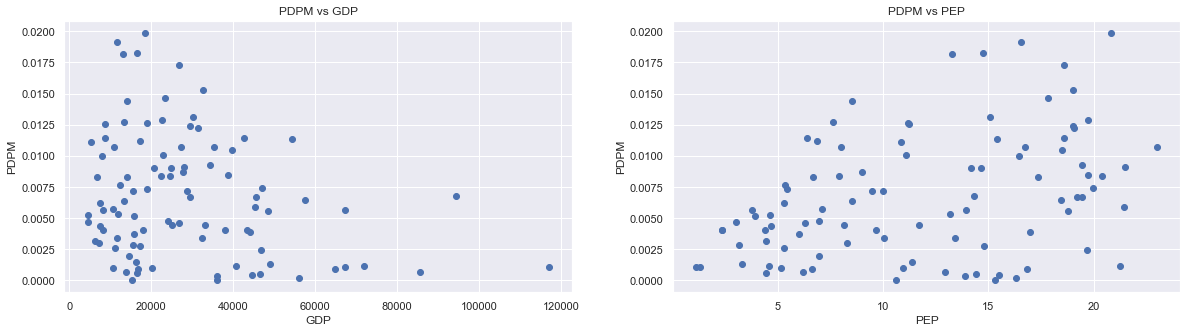

In [48]:
#Read the CSV file, Set target label & feature labels 
df, target_label,feature1_label,feature2_label = pd.read_csv("Death_Dataset3.csv"),"PDPM","GDP","PEP"
# Extract the features and the targets
df_features, df_target = get_features_targets(df,[feature1_label,feature2_label],[target_label])
fig , axes = plt.subplots(1,2,figsize = (20,5))
axes[0].scatter(df_features[feature1_label], df_target)
axes[0].set(xlabel= feature1_label, ylabel = target_label, title = target_label + " vs " + feature1_label)
axes[1].scatter(df_features[feature2_label], df_target)
axes[1].set(xlabel= feature2_label, ylabel = target_label, title = target_label + " vs " + feature2_label)

# Observations
We observe from the PDPM vs. GDP graph (left) that the relationship is not linear, hence we transformed the GDP feature to **1/GDP** and **LOG(GDP)** and calculated the MSE to measure the quality of our estimation model. R^2 measurement was not used as it does not show whether the right model is chosen and the predicted capacity of the obtained fit.

The code below executes the described operation, displays all the outputs in a subplot and calculates the Beta coefficients of our model.
$$\hat{y} =  \beta_0 + \beta_1 x_1 + \beta_2 x_2$$
$$x_1 = GDP , \frac{1}{GDP} , \log(GDP)$$
$$x_2 = PEP$$

The PDPM vs. PEP still displays outliers that has PDPM < 0.0025% while PEP > 15%. This may indicate that the data could require more trimming but for our current model, we will continue to use these countries to explore the effect of such outliers on our regression model.

MSE GDP : 1.74974856676384e-05
| Beta 0 : [0.00675737] | Beta 1 : [-0.00177525] | Beta 2 : [0.00230043] |
MSE 1/GDP : 1.8834257365831767e-05
| Beta 0 : [0.00675737] | Beta 1 : [0.00140985] | Beta 2 : [0.00249401] |
MSE LOG(GDP) : 1.744917013934272e-05
| Beta 0 : [0.00675737] | Beta 1 : [-0.00189291] | Beta 2 : [0.00264044] |


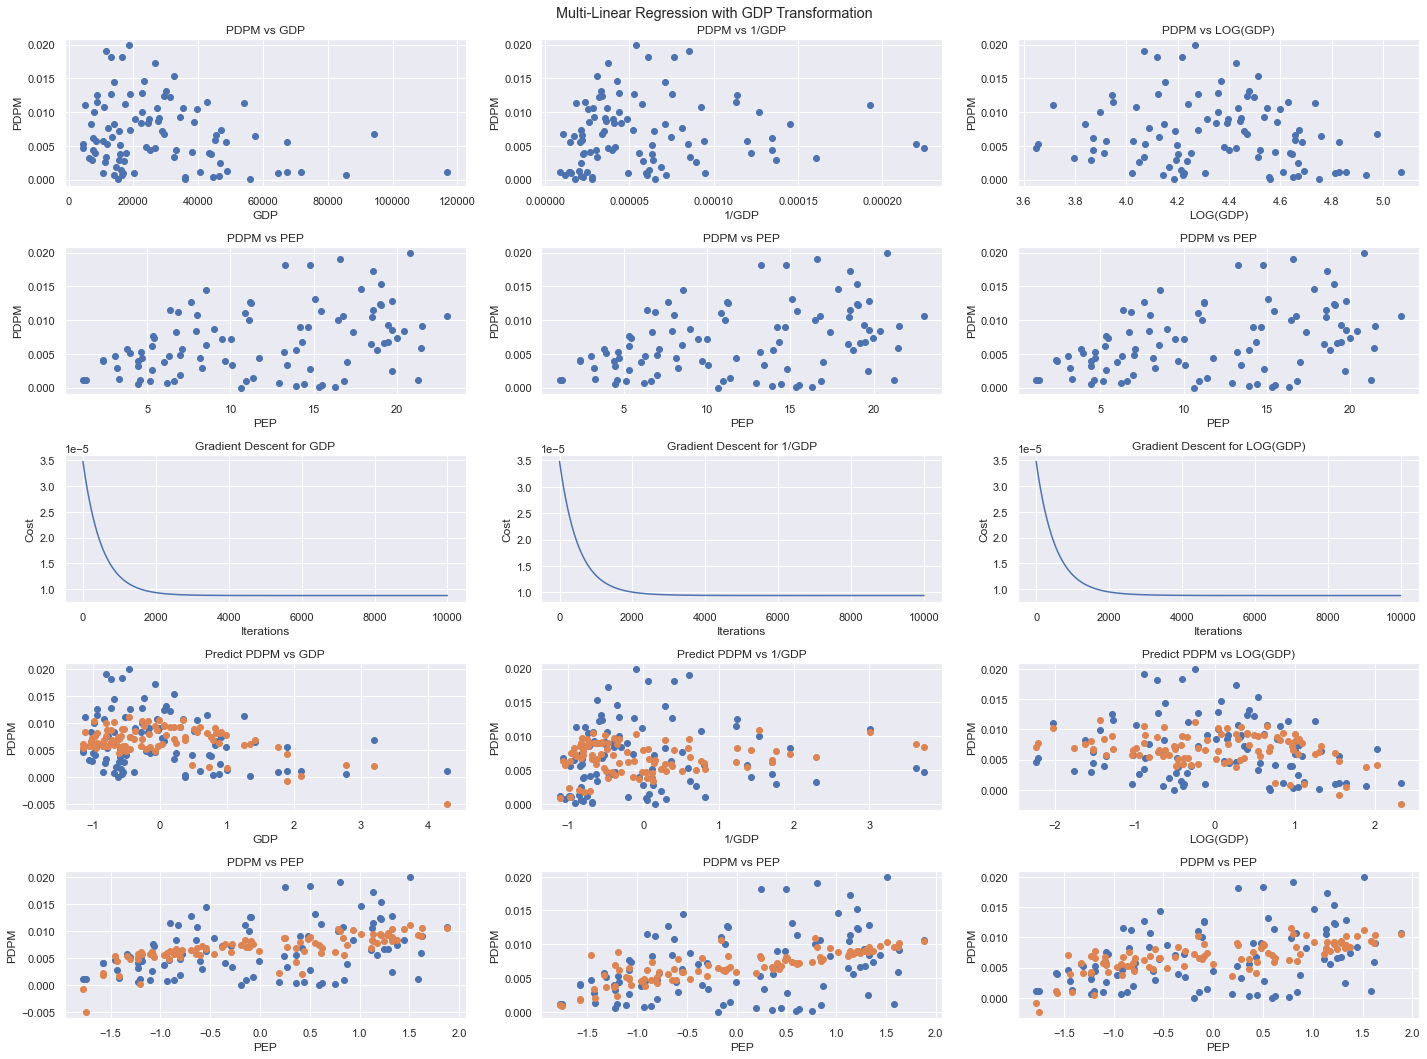

In [49]:
#Set transformed GDP labels
feature1_label_transform1,feature1_label_transform2 = "1/GDP","LOG(GDP)"
feature_arr = [feature1_label,feature1_label_transform1,feature1_label_transform2]


# Extract the features and the targets
df_features_t1, df_target = get_features_targets(df,[feature1_label_transform1,feature2_label],[target_label])
df_features_t2, df_target = get_features_targets(df,[feature1_label_transform2,feature2_label],[target_label])


#Creating Subplots to put multiple graphs
fig , axes = plt.subplots(5,3,figsize = (20,15))

#Storing of beta,pred,mse for each GDP transformation
betas,preds,mses = [None]*3,[None]*3,[None]*3

for col_GDP in range(len(feature_arr)): #Applies MLR. Finds the Beta coefficients and model prediction for each GDP transformation
    if col_GDP == 0:
        df_features_z,feature = normalize_z(df_features),df_features
    elif col_GDP == 1:
        df_features_z,feature = normalize_z(df_features_t1),df_features_t1
    elif col_GDP == 2:
        df_features_z,feature = normalize_z(df_features_t2),df_features_t2
        
    #Plotting each GDP transformation
    subplot_display(axes,0,col_GDP,feature_arr[col_GDP],target_label,feature[feature_arr[col_GDP]],df_target,target_label+" vs "+feature_arr[col_GDP])
    
    #Change the features and the target to numpy array using the prepare functions
    X, target = prepare_feature(df_features_z), prepare_target(df_target)
    iterations, alpha = 10000 , 0.001
    beta = np.zeros((X.shape[1],1)) #b0 + b1x1 + b2x2
    betas[col_GDP], J_storage = gradient_descent_multi(X, target, beta, alpha, iterations)
    
    #Plotting Gradient Descent, Predicted PDPM vs GDP, Predicted PDPM vs PEP
    subplot_display(axes,1,col_GDP,feature2_label,target_label,df_features[feature2_label],df_target,target_label +" vs "+feature2_label)# PDPM vs PEP
    subplot_display(axes,2,col_GDP,"Iterations","Cost",J_storage,pd.DataFrame(),"Gradient Descent for "+ feature_arr[col_GDP])# Gradient Descent of Cost
    preds[col_GDP] = predict(df_features_z,betas[col_GDP])
    subplot_display(axes,3,col_GDP,feature_arr[col_GDP],target_label,df_features_z[feature_arr[col_GDP]],df_target,"Predict " + target_label + " vs " + feature_arr[col_GDP])#PDPM vs GDP
    axes[3][col_GDP].scatter(df_features_z[feature_arr[col_GDP]], preds[col_GDP])#Predicted PDPM vs GDP
    subplot_display(axes,4,col_GDP,feature2_label,target_label,df_features_z[feature2_label],df_target,target_label +" vs "+feature2_label)#PDPM vs PEP
    axes[4][col_GDP].scatter(df_features_z[feature2_label], preds[col_GDP])#Predicted PDPM vs PEP
    
    #Calculate MSE to determine accuracy
    target = prepare_target(df_target)
    mses[col_GDP] = mean_squared_error(target,preds[col_GDP])
    
    #Printing out the MSE & Beta Coefficient for each linear regression
    print("MSE {} : {}".format(feature_arr[col_GDP],mses[col_GDP]))
    beta_str = "|"
    for i in range(len(betas[col_GDP])):
        beta_str += " Beta {} : {} |".format(i,betas[col_GDP][i])
    print(beta_str)

fig.suptitle("Multi-Linear Regression with GDP Transformation")
fig.tight_layout()#To fit plots within figure cleanly

# Residual Plotting
[Residual plots](https://blog.minitab.com/en/adventures-in-statistics-2/why-you-need-to-check-your-residual-plots-for-regression-analysis) was used to observe the error (difference between the observed and expected value) and determine if our model is a good fit. If the error is unpredictable (ie no visible trend), that indicates that our model is good at predicting the expected value.

$$e = y - \hat{y}$$

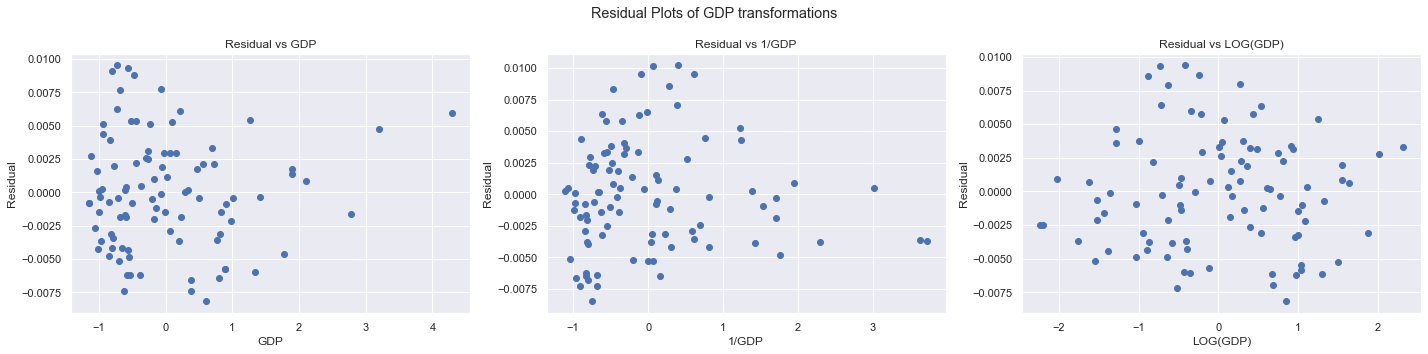

In [50]:
#Graphing the Residual Plots (Residual = Observed - Predicted)
R_fig , R_axes = plt.subplots(1,3,figsize = (20,5))
errors= [None]*3
for col in range(len(feature_arr)):
    if col == 0:
        df_features_z = normalize_z(df_features)
    elif col == 1:
        df_features_z = normalize_z(df_features_t1)
    elif col == 2:
        df_features_z = normalize_z(df_features_t2)
    errors[col] = df_target - preds[col]
    R_axes[col].scatter(df_features_z[feature_arr[col]], errors[col])
    R_axes[col].set(xlabel= feature_arr[col], ylabel = "Residual", title =  "Residual vs " + feature_arr[col])
R_fig.suptitle("Residual Plots of GDP transformations")
R_fig.tight_layout()#To fit plots within figure cleanly

# Part 1 Conclusion
We can conclude that LOG(GDP) transformation is the best fit of our model due to the following:
- MSE for LOG(GDP) transformation has the lowest in comparison to the other models
- Residual plot of the LOG(GDP) is the most random and unpredictable compared to GDP and 1/GDP transformation
- LOG(GDP) show homoscedasticity, whereas GDP and 1/GDP residual plots shows heteroscedasticity indicating that the LOG(GDP) has a better fit linear regression model,

There is also linear correlation of GDP and PEP to PDPM as we hypothesised.

**MSE** (Smallest to largest)
- `LOG(GDP): 1.7449170139342724e-05`
- GDP: 1.74974856676384e-05
- 1/GDP: 1.8834257365831764e-05

Our MLR Regression for Predicting PDPM:
$$ \hat{y} = 0.00675737 -0.00189291*NORM(LOG(GDP)) + 0.00264044*NORM(PEP)$$

# Part 2

### Overview About the Problem

Describe here the problem you are trying to solve.

COVID-19 vaccination rates in the world are affected by a number of factors. While economic factors, such as the countries' healthcare infrastructure and Gross Domestic Product (GDP) may affect their ability to obtain vaccines, another important factor is the public's perception of taking the vaccine. In this digitalised age, where media and internet play a huge role in spreading information about vaccination, we see how might the total vaccination number of a country is dependent on the freedom of press in the country and the percentage of population having access to internet. Does a greater accessibility to the internet  promote vaccination rates by allowing greater communication to the public, or does it hamper vaccination rates by providing a medium for potential misinformation to spread? Likewise, do countries with a "controlled" press do better at their vaccination programs than those which are more "free"?

### Dataset

The dataset contains 4 columns namely:

1. location: Country name
2. max_vacc: Maximum vaccinated people per 100. This column was calculated by finding the maximum % of people vaccinated at any point of time in the country. 
3. Freedom of Press: Freedom of press index for 2021. The higher the index, the more "free" the press in that country is. Detailed methology on how the index was calculated can be found <a href = "https://rsf.org/en/detailed-methodology">here</a>.
4. Internet: Percentage of population having access to internet


Sources of dataset

1. Freedom of Press Index: https://rsf.org/en/ranking_table?
2. Internet indicator: https://data.worldbank.org/indicator/IT.NET.USER.ZS
3. Vaccination data: https://github.com/owid/covid-19-data/tree/master/public/data

The data was obtained from these sources and merged based on the country/location. As the datasets do not include all countries, some data may have 1 blank feature, although during modelling they are filtered out. 

In [42]:
import numpy as np
import seaborn as sns
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import math

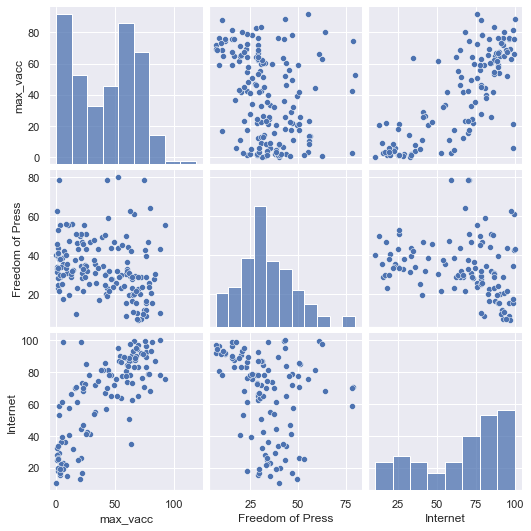

In [43]:
df = pd.read_csv("vacc_vs_trustmediagov_net.csv")
sns.set()
sns.pairplot(df,x_vars=["max_vacc","Freedom of Press","Internet"], y_vars=["max_vacc","Freedom of Press","Internet"])

### Features and Target Preparation

Describe here what are the features you use and why these features. Put any Python codes to prepare and clean up your features. 

Do the same thing for the target. Describe your target and put any codes to prepare your target.

1. Features: 

    i. Freedom of Press: The Freedom of press index of a country 
    
    ii. Internet: Percentage population who have access to internet in a country
    
 
2. Target: 

    i. max_vacc: Total vaccination of the country in 2021

In [44]:
# put Python code to prepare your featuers and target
def prepare_feature(df_feature):
    length = len(df_feature)
    return np.concatenate((np.ones((length, 1)), df_feature.to_numpy()), axis = 1)

#converts the target dataframe into a numpy arra
def prepare_target(df_target):
    return df_target.to_numpy()

### Building Model

Describe your model. Is this Linear Regression or Logistic Regression? Put any other details about the model. Put the codes to build your model.

We will be implementing Multiple Linear Regression on the features and target, this is because from the plot we can observe that the max_vacc is strictly increasing with Internet whereas decresing with Freedom of press index

In [14]:
rstate = 1500 #global random state value
bestmodel = {}#a dictionary to store all mse values to compare the models accuracy

In [18]:
# put Python code to build your model

#takes in the dataframe, and lists of columns for features and targets, and returns the dataframes for each
def get_features_targets(df, feature_names, target_names):
    df_feature = df.loc[:,feature_names]
    df_target = df.loc[:,target_names]
    return df_feature, df_target
 
def normalize_z(dfin, columns):
    dfout = dfin.copy()
    for column in columns:
#         print(column)
        column_frame = dfout[column]
        mean = column_frame.mean(axis=0)
        std = column_frame.std(axis=0)
        dfout[column] = dfout[column].subtract(mean).div(std)
    return dfout


#takes in a dataframe and normalizes using z score
def compute_cost(X, y, beta):
    m = len(X)
    difference = np.matmul(X, beta) - y
    J = (np.matmul(np.transpose(difference), difference)) / (2 * m)
    
    return J[0][0]


#given beta feature dataframe, outputs the predicted y values
def predict(df_feature, beta):
    dfin = prepare_feature(df_feature)
    y = predict_norm(dfin, beta)
    return y

#used by predict, simply multiplies the X by beta values to give the y values
def predict_norm(X, beta):
    y = np.matmul(X,beta)
    return y

#takes in a feature and target dataframe, each with the same number of rows, and random_state and test_size, outputting
#the train and test dataframe for feature and target
def split_data(df_feature, df_target, random_state=None, test_size=0.5):
    indexes = df_feature.index
    if random_state:
        np.random.seed(random_state)
    
    k = int(test_size*len(indexes))
    test_index = np.random.choice(indexes,k,replace=False)
    
    indexes = set(indexes)
    test_index = set(test_index)
    train_index = indexes - test_index
    
    df_feature_train = df_feature.loc[train_index,:]
    df_feature_test = df_feature.loc[test_index,:]
    df_target_train = df_target.loc[train_index,:]
    df_target_test = df_target.loc[test_index,:]
    
    return df_feature_train, df_feature_test, df_target_train, df_target_test

#performs gradient descent algorithm with FIXED iterations
def gradient_descent(X, y, beta, alpha, num_iters):
    J_storage = []
    m = len(X)
    
    for i in range(num_iters):
        step = alpha * (np.matmul(np.transpose(X), np.matmul(X, beta) - y)) / m
        beta = beta - step
        #print(beta)
        J_storage.append(compute_cost(X,y,beta))
    return beta, J_storage

#the modified function executes the gradienct descent, plots the model, calcualted the mean square error and appends it to a dictionary
#plot is a boolean value which indicates if the model needs to be plotted

def gradient_descent_better(features, target, beta, alpha, num_iters, df, test_size = 0.5,randomstate = None, plot = True):
    dfcopy = df.copy()
    dfcopy = dfcopy.dropna(subset=features + target)
    
    #display(df)
    df_feature = dfcopy.loc[:,features]
    df_target = dfcopy.loc[:,target]
    df_feature_train, df_feature_test, df_target_train, df_target_test = split_data(df_feature, df_target, test_size = test_size,random_state=randomstate)
    
    #normalize sets
    df_feature_test = normalize_z(df_feature_test, features)
    df_feature_train = normalize_z(df_feature_train, features)
    
    X = prepare_feature(df_feature_train)
    y = prepare_target(df_target_train)
    
    beta, J_storage = gradient_descent(X, y, beta, alpha, num_iters)
    pred = predict(df_feature_test, beta)
    
    
    #to check if the graph needs to be plot
    if(plot):
        plt.figure(0)
        plt.plot(df_feature_test[features[0]],df_target_test, 'o')
        plt.xlabel("")
        plt.plot(df_feature_test[features[0]],pred,'o')
    
    preptargettest = prepare_target(df_target_test)

    #adds the mse value to a dictionary with feature names as key
    modelname = ""
    for x in features:
        modelname+=x+", "
    bestmodel[modelname] = mean_squared_error(preptargettest, pred)[0][0]

#### Multiple Linear Regression
$$y =  \beta_0 + \beta_1 x_1 + \beta_2 x_2$$
$$x_1 = Internet$$
$$x_2 = Freedom\ of\ Press$$
$$y = max\ vacc$$

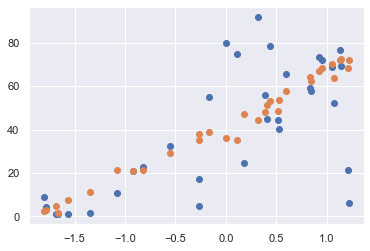

In [19]:
#linear regression model, kindly run this after runnning the python code cell below containing mean square error function as gradient descent better function calculated mse as well

def linear_multiple_model(plot,randstate):
    df = pd.read_csv("vacc_vs_trustmediagov_net.csv")
    sns.set()
    gradient_descent_better(["Internet", "Freedom of Press"], ["max_vacc"], np.zeros((3,1)), 0.001, 10000, df, test_size = 0.3,randomstate=randstate,plot=plot)

linear_multiple_model(True,rstate)

### Evaluating the Model

Describe your metrics and how you want to evaluate your model. Put any Python code to evaluate your model. Use plots to have a visual evaluation.

We are evaluating our model using mean square error value. We want the mean square error to be as low as possible

In [20]:
# put Python code to evaluate the model and to visualize its accuracy

#calculates the Mean Square Error of the target and predicted value
def mean_squared_error(target, pred):
    difference = target - pred
    n = len(target)
    return np.matmul(np.transpose(difference), difference) / n


In [21]:
print(bestmodel)



{'Internet, Freedom of Press, ': 483.3505016102056}


### Improving the Model

Discuss any steps you can do to improve the models. Put any python codes. You can repeat the steps above with the codes to show the improvement in the accuracy. 

The mean square value is quite high as seen above, which means that the model is not very accurate. We will now try the following 
1. Model using multiple linear regression of logarithmic of features
2. Model multiple linear regression of exponential of features
3. Model using polynomial expression of degree 2 
4. Model using polynomial expression of degree 3 
The data looks to be strictly increasing, we will not try polynomial expression of higher degrees as higher degree polynomials will have more points of maxima and minima, however this data is increasing throughout and hence higher degree won't be suitable in modelling

In [22]:
#adds a negative exponential column of the feature i.e 
def transform_featuresexp(df_feature, colname, colname_transformed):
    dfout = df_feature.copy()
    dfout[colname_transformed] = math.exp(1) ** (-dfout[colname])
    return dfout

#adds a logarithmic column of the feature
def transform_featureslog(df_feature, colname, colname_transformed):
    dfout = df_feature.copy()
    dfout[colname_transformed] = np.log(dfout[colname])
    return dfout

#adds a quadratic column of the feature
def transform_featuresquad(df_feature, colname, colname_transformed):
    dfout = df_feature.copy()
    dfout[colname_transformed] = dfout[colname] ** 2
    return dfout

#adds a cubic column of the feature
def transform_featurescubic(df_feature, colname, colname_transformed):
    dfout = df_feature.copy()
    dfout[colname_transformed] = dfout[colname] ** 3
    return dfout



#### Logarithmic Regression

$$y =  \beta_0 + \beta_1 log(x_1) + \beta_2 log(x_2)$$
$$x_1 = Internet$$
$$x_2 = Freedom\ of\ Press$$
$$y = max\ vacc$$

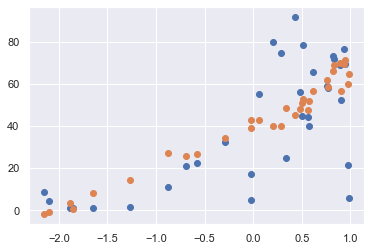

In [23]:
def log_multiple_model(plot,randstate):


    df = pd.read_csv("vacc_vs_trustmediagov_net.csv")
    sns.set()

    df = transform_featureslog(df,"Freedom of Press","log(Freedom of Press)")
    df = transform_featureslog(df,"Internet","log(Internet)")

    gradient_descent_better(["log(Internet)", "log(Freedom of Press)"], ["max_vacc"], np.zeros((3,1)), 0.001, 10000, df, test_size = 0.3,randomstate=rstate,plot=plot)

log_multiple_model(True,rstate)

$$y =  \beta_0 + \beta_1 log(x_1) + \beta_2 x_2$$
$$x_1 = Internet$$
$$x_2 = Freedom\ of\ Press$$
$$y = max\ vacc$$

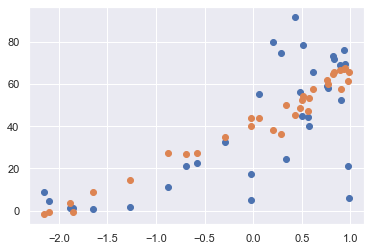

In [24]:
def log_internet_multiple_model(plot,randstate):


    df = pd.read_csv("vacc_vs_trustmediagov_net.csv")
    sns.set()

    df = transform_featureslog(df,"Internet","log(Internet)")

    gradient_descent_better(["log(Internet)", "Freedom of Press"], ["max_vacc"], np.zeros((3,1)), 0.001, 10000, df, test_size = 0.3,randomstate=randstate,plot=plot)

log_internet_multiple_model(True,rstate)


$$y =  \beta_0 + \beta_1 x_1 + \beta_2 log(x_2)$$
$$x_1 = Internet$$
$$x_2 = Freedom\ of\ Press$$
$$y = max\ vacc$$

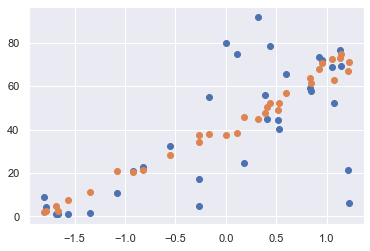

In [25]:
def log_freedomofpress_multiple_model(plot,randstate):

    df = pd.read_csv("vacc_vs_trustmediagov_net.csv")
    sns.set()

    df = transform_featureslog(df,"Freedom of Press","log(Freedom of Press)")

    gradient_descent_better(["Internet", "log(Freedom of Press)"], ["max_vacc"], np.zeros((3,1)), 0.001, 10000, df, test_size = 0.3,randomstate=randstate,plot=plot)

log_freedomofpress_multiple_model(True,rstate)

#### Exponential Regression

$$y =  \beta_0 + \beta_1 x_1 + \beta_2 e^{-x_2}$$
$$x_1 = Internet$$
$$x_2 = Freedom\ of\ Press$$
$$y = max\ vacc$$

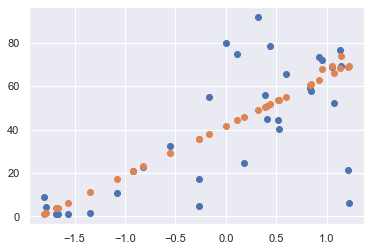

In [26]:
def exp_freedomofpress_multiple_model(plot,randstate):
    df = pd.read_csv("vacc_vs_trustmediagov_net.csv")
    df = transform_featuresexp(df,"Freedom of Press","exp(Freedom of Press)")


    sns.set()
    gradient_descent_better(["Internet","exp(Freedom of Press)"], ["max_vacc"], np.zeros((3,1)), 0.001, 10000, df, test_size = 0.3,randomstate=randstate,plot=plot)

exp_freedomofpress_multiple_model(True,rstate)

#### Multiple Quadratic Regression 

$$y =  \beta_0 + \beta_1 x_1 + \beta_2 x_2^2$$
$$x_1 = Internet$$
$$x_2 = Freedom\ of\ Press$$
$$y = max\ vacc$$

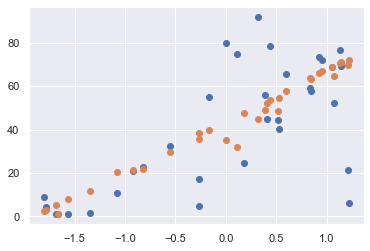

In [27]:
def quad_freedom_multiple_model(plot,randstate):

    df = pd.read_csv("vacc_vs_trustmediagov_net.csv")
    df = transform_featuresquad(df,"Freedom of Press","Freedom of Press^2")

    sns.set()

    gradient_descent_better(["Internet", "Freedom of Press^2"], ["max_vacc"], np.zeros((3,1)), 0.001, 10000, df, test_size = 0.3,randomstate=randstate,plot=plot)

quad_freedom_multiple_model(True,rstate)


$$y =  \beta_0 + \beta_1 x_1^2 + \beta_2 x_2$$
$$x_1 = Internet$$
$$x_2 = Freedom\ of\ Press$$
$$y = max\ vacc$$

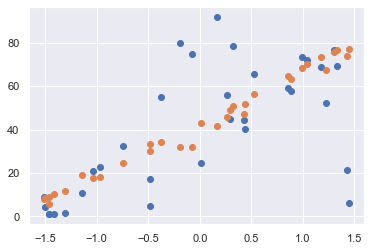

In [28]:
def quad_internet_multiple_model(plot,randstate):
    df = pd.read_csv("vacc_vs_trustmediagov_net.csv")
    df = transform_featuresquad(df,"Internet","Internet^2")
    sns.set()
    gradient_descent_better(["Internet^2", "Freedom of Press"], ["max_vacc"], np.zeros((3,1)), 0.001, 10000, df, test_size = 0.3,randomstate=randstate,plot=plot)


quad_internet_multiple_model(True,rstate)

$$y =  \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_2^2$$
$$x_1 = Internet$$
$$x_2 = Freedom\ of\ Press$$
$$y = max\ vacc$$

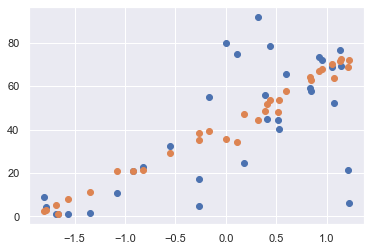

In [29]:
def quad_freedom_linear_multiple_model(plot,randstate):
    df = pd.read_csv("vacc_vs_trustmediagov_net.csv")
    df = transform_featuresquad(df,"Freedom of Press","Freedom of Press^2")
    sns.set()
    gradient_descent_better(["Internet","Freedom of Press","Freedom of Press^2"], ["max_vacc"], np.zeros((4,1)), 0.001, 10000, df, test_size = 0.3,randomstate=randstate,plot=plot)

quad_freedom_linear_multiple_model(True,rstate)

$$y =  \beta_0 + \beta_1 x_1 + \beta_2 x_1^2 + \beta_3 x_2$$
$$x_1 = Internet$$
$$x_2 = Freedom\ of\ Press$$
$$y = max\ vacc$$

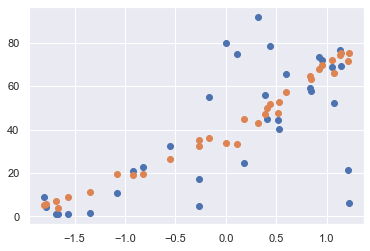

In [30]:
def quad_internet_linear_multiple_model(plot,randstate):
    df = pd.read_csv("vacc_vs_trustmediagov_net.csv")
    df = transform_featuresquad(df,"Internet","Internet^2")

    sns.set()
    gradient_descent_better(["Internet","Internet^2","Freedom of Press"], ["max_vacc"], np.zeros((4,1)), 0.001, 10000, df, test_size = 0.3,randomstate=randstate,plot=plot)

    
quad_internet_linear_multiple_model(True,rstate)

$$y =  \beta_0 + \beta_1 x_1^2 + \beta_3 x_2^2$$
$$x_1 = Internet$$
$$x_2 = Freedom\ of\ Press$$
$$y = max\ vacc$$

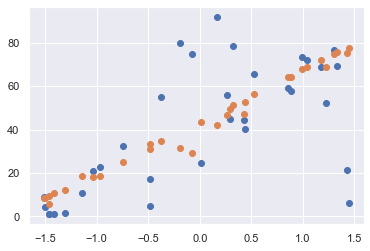

In [31]:
def quad_internet_freedom_multiple_model(plot,randstate):

    df = pd.read_csv("vacc_vs_trustmediagov_net.csv")
    df = transform_featuresquad(df,"Internet","Internet^2")
    df = transform_featuresquad(df,"Freedom of Press","Freedom of Press^2")

    sns.set()

    gradient_descent_better(["Internet^2", "Freedom of Press^2"], ["max_vacc"], np.zeros((3,1)), 0.001, 10000, df, test_size = 0.3,randomstate=randstate,plot=plot)
    

quad_internet_freedom_multiple_model(True,rstate)    

$$y =  \beta_0 + \beta_1 x_1 + \beta_2 x_1^2 + \beta_3 x_2 + \beta_4 x_2^2$$
$$x_1 = Internet$$
$$x_2 = Freedom\ of\ Press$$
$$y = max\ vacc$$

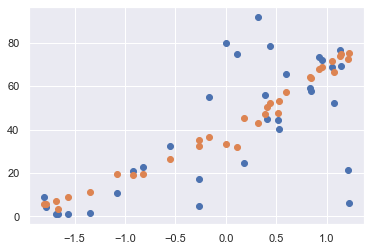

In [32]:
def quad_internet_freedom_linear_multiple_model(plot,randstate):


    df = pd.read_csv("vacc_vs_trustmediagov_net.csv")

    df = transform_featuresquad(df,"Internet","Internet^2")
    df = transform_featuresquad(df,"Freedom of Press","Freedom of Press^2")

    sns.set()
    gradient_descent_better(["Internet","Internet^2","Freedom of Press","Freedom of Press^2"], ["max_vacc"], np.zeros((5,1)), 0.001, 10000, df, test_size = 0.3,randomstate=randstate,plot=plot)

quad_internet_freedom_linear_multiple_model(True,rstate)

#### Multiple Cubic Regression

$$y =  \beta_0 + \beta_1 x_1^3 + \beta_2 x_2^2 $$
$$x_1 = Internet$$
$$x_2 = Freedom\ of\ Press$$
$$y = max\ vacc$$

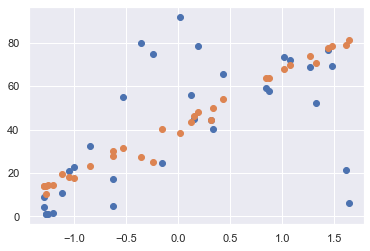

In [33]:
def cubic_internet_quad_freedom_multiple_model(plot,randstate):
    df = pd.read_csv("vacc_vs_trustmediagov_net.csv")
    df = transform_featurescubic(df,"Internet","Internet^3")
    df = transform_featuresquad(df,"Freedom of Press","Freedom of Press^2")
    sns.set()
    gradient_descent_better(["Internet^3", "Freedom of Press^2"], ["max_vacc"], np.zeros((3,1)), 0.001, 10000, df, test_size = 0.3,randomstate=randstate,plot=plot)
cubic_internet_quad_freedom_multiple_model(True,rstate)

$$y =  \beta_0 + \beta_1 x_1^3 + \beta_2 x_2^3$$
$$x_1 = Internet$$
$$x_2 = Freedom\ of\ Press$$
$$y = max\ vacc$$

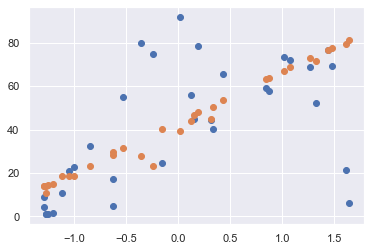

In [34]:
def cubic_internet_freedom_multiple_model(plot,randstate):

    df = pd.read_csv("vacc_vs_trustmediagov_net.csv")
    df = transform_featurescubic(df,"Internet","Internet^3")
    df = transform_featurescubic(df,"Freedom of Press","Freedom of Press^3")

    sns.set()
    gradient_descent_better(["Internet^3", "Freedom of Press^3"], ["max_vacc"], np.zeros((3,1)), 0.001, 10000, df, test_size = 0.3,randomstate=randstate,plot=plot)
cubic_internet_freedom_multiple_model(True,rstate)

$$y =  \beta_0 + \beta_1 x_1^2 + \beta_2 x_1^3 + \beta_3 x_2 + \beta_4 x_2^2 + \beta_5 x_2^3$$
$$x_1 = Internet$$
$$x_2 = Freedom\ of\ Press$$
$$y = max\ vacc$$

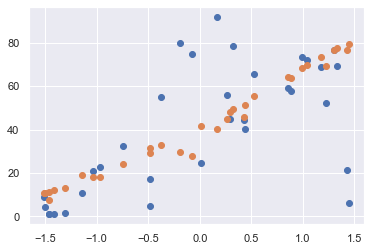

In [35]:
def cubic_quad_internet_freedom_lin_multiple_model(plot,randstate):

    df = pd.read_csv("vacc_vs_trustmediagov_net.csv")

    df = transform_featuresquad(df,"Internet","Internet^2")
    df = transform_featuresquad(df,"Freedom of Press","Freedom of Press^2")
    df = transform_featurescubic(df,"Internet","Internet^3")
    df = transform_featurescubic(df,"Freedom of Press","Freedom of Press^3")

    sns.set()
    gradient_descent_better(["Internet^2","Internet^3","Freedom of Press","Freedom of Press^2","Freedom of Press^3"], ["max_vacc"], np.zeros((6,1)), 0.001, 10000, df, test_size = 0.3,randomstate=randstate,plot=plot)

cubic_quad_internet_freedom_lin_multiple_model(True,rstate)

$$y =  \beta_0 + \beta_1 x_1 + \beta_2 x_1^2 + \beta_3 x_1^3 + \beta_4 x_2^2 + \beta_5 x_2^3$$
$$x_1 = Internet$$
$$x_2 = Freedom\ of\ Press$$
$$y = max\ vacc$$

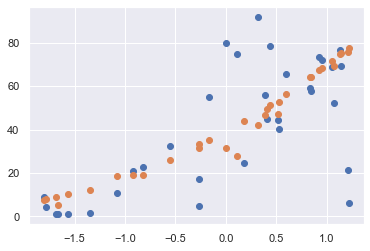

In [36]:
def cubic_quad_lin_internet_freedom_multiple_model(plot,randstate):

    df = pd.read_csv("vacc_vs_trustmediagov_net.csv")

    df = transform_featuresquad(df,"Internet","Internet^2")
    df = transform_featuresquad(df,"Freedom of Press","Freedom of Press^2")
    df = transform_featurescubic(df,"Internet","Internet^3")
    df = transform_featurescubic(df,"Freedom of Press","Freedom of Press^3")

    sns.set()
    gradient_descent_better(["Internet","Internet^2","Internet^3","Freedom of Press^2","Freedom of Press^3"], ["max_vacc"], np.zeros((6,1)), 0.001, 10000, df, test_size = 0.3,randomstate=randstate,plot=plot)

cubic_quad_lin_internet_freedom_multiple_model(True,rstate)

$$y =  \beta_0 + \beta_1 x_1 + \beta_2 x_1^2 + \beta_3 x_1^3 + \beta_4 x_2 + \beta_5 x_2^2 + \beta_6 x_2^3$$
$$x_1 = Internet$$
$$x_2 = Freedom\ of\ Press$$
$$y = max\ vacc$$

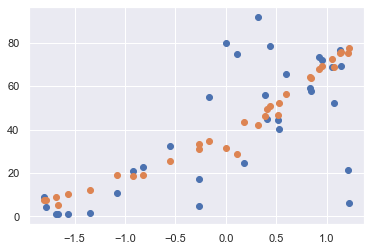

In [37]:
def cubic_quad_lin_all_internet_freedom_multiple_model(plot,randstate):


    df = pd.read_csv("vacc_vs_trustmediagov_net.csv")

    df = transform_featuresquad(df,"Internet","Internet^2")
    df = transform_featuresquad(df,"Freedom of Press","Freedom of Press^2")
    df = transform_featurescubic(df,"Internet","Internet^3")
    df = transform_featurescubic(df,"Freedom of Press","Freedom of Press^3")

    sns.set()
    gradient_descent_better(["Internet","Internet^2","Internet^3","Freedom of Press","Freedom of Press^2","Freedom of Press^3"], ["max_vacc"], np.zeros((7,1)), 0.001, 10000, df, test_size = 0.3,randomstate=randstate,plot=plot)

cubic_quad_lin_all_internet_freedom_multiple_model(True,rstate)

### Discussion and Analysis

Discuss your model and accuracy in solving the problem. Analyze the results of your metrics. Put any conclusion here.

We have stored the mean sqaure error values of all models in a dictionary called bestmodel. Now we will create another dictionary called sorted_modellist which will have the keys in ascending order of the values. Then we will convert the dictonary to a datafram for better visualisation of the mean square error values of the model

In [38]:

#sort the disctionary in ascending order of mse value
sorted_modellist = {}
sorted_keys = sorted(bestmodel, key=bestmodel.get)

for w in sorted_keys:
    sorted_modellist[w] = bestmodel[w]
    
#converting the sorted dictionary to a dataframe for easier visualistaion
sorted_df_model_mse = pd.DataFrame.from_dict(sorted_modellist,orient='index',columns=["Mean Square Error"])
sorted_df_model_mse

,Mean Square Error
"log(Internet), log(Freedom of Press),",432.456518
"Internet, exp(Freedom of Press),",434.905230
"Internet, log(Freedom of Press),",460.072693
"log(Internet), Freedom of Press,",460.520289
"Internet, Freedom of Press,",483.350502
"Internet, Freedom of Press, Freedom of Press^2,",488.688901
"Internet, Freedom of Press^2,",499.339023
"Internet, Internet^2, Freedom of Press,",517.475118
"Internet, Internet^2, Freedom of Press, Freedom of Press^2,",525.712499
"Internet^2, Freedom of Press,",547.624317


These are the mean square error values when the random state was equal to 1500. On running the test with other random states we have seen that the mean square error value changes. Therefore, we want a model which has a consistent low mean sqaure error across different random state. Hence, we will execute the above models within a range of random states. We will then average the mean sqaure error value of the model over all the random states and compare them 

In [39]:
#finding the mse of the above models for different random states
ranstates = list(range(100,1500,100))#list of different random states

#looping through each random state

for rs in ranstates:
    #linear
    #False ensures the model does not plot the data
    linear_multiple_model(False,rs)
        
    #logarithmic 
    log_multiple_model(False,rs)
    log_internet_multiple_model(False,rs)
        
    #exponential
    exp_freedomofpress_multiple_model(False,rs)

        
    #quad
    quad_freedom_multiple_model(False,rs)
    quad_internet_multiple_model(False,rs)       
    quad_freedom_linear_multiple_model(False,rs)   
    quad_internet_linear_multiple_model(False,rs)   
    quad_internet_freedom_linear_multiple_model(False,rs)

        
    #cubic
    cubic_internet_quad_freedom_multiple_model(False,rs)   
    cubic_internet_freedom_multiple_model(False,rs)
    cubic_quad_internet_freedom_lin_multiple_model(False,rs)   
    cubic_quad_lin_internet_freedom_multiple_model(False,rs)    
    cubic_quad_lin_all_internet_freedom_multiple_model(False,rs)

    
    #adding all the mse values for each model obtained for each random state 
    for k,v in bestmodel.items():
        sorted_modellist[k]+=bestmodel[k]

In [40]:
#averaging the mse values over all random states
for k,v in sorted_modellist.items():
    sorted_modellist[k]/=(len(ranstates)+1)

In [41]:
#sort the disctionary in ascending order of avg mse value
sorted_model_avg_mse_list = {}
sorted_keys = sorted(sorted_modellist, key=sorted_modellist.get)

for w in sorted_keys:
    sorted_model_avg_mse_list[w] = sorted_modellist[w]
    
#converting the sorted dictionary to a dataframe for easier visualistaion
sorted_df_model_avg_mse = pd.DataFrame.from_dict(sorted_model_avg_mse_list,orient='index',columns=["Mean Square Error"])
sorted_df_model_avg_mse

,Mean Square Error
"Internet, exp(Freedom of Press),",386.621368
"Internet, Freedom of Press, Freedom of Press^2,",399.430074
"Internet, Freedom of Press,",401.417065
"Internet, Freedom of Press^2,",401.687314
"Internet, Internet^2, Freedom of Press, Freedom of Press^2,",404.674693
"Internet, Internet^2, Freedom of Press,",405.505829
"Internet, Internet^2, Internet^3, Freedom of Press^2, Freedom of Press^3,",413.167989
"Internet, Internet^2, Internet^3, Freedom of Press, Freedom of Press^2, Freedom of Press^3,",413.316006
"Internet^2, Freedom of Press,",415.916828
"Internet^2, Internet^3, Freedom of Press, Freedom of Press^2, Freedom of Press^3,",429.094146


### Conclusion

On repeating the above models with different random state values, we observe that **mutiple linear regression model of Internet and exponential (Freedom of Press)** consistently gets a lower mean sqaure error value compared to other models.

$$y =  \beta_0 + \beta_1 x_1 + \beta_2 e^{-x_2}$$
$$x_1 = Internet$$
$$x_2 = Freedom\ of\ Press$$
$$y = max\ vacc$$

 Hence the total vaccination of a country is linearly dependent on the percentage population having internet access and negative exponentially dependent on the Freedom of press index. This result is also consistent with the individual dependency of these variables in the individual graphs. 

However, we note that the relationship with internet % and vaccination % may be a case of correlation and not causation. For example, higher internet % may be a result of better infrastructure which affects how much access the country may have to vaccines. Thus, more models and data may be required to establish this relationship.